# Bi- Directional LSTM neural network whitout K-Fold Cross Validation

* Impostazione per uso della GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow import keras
from keras import layers
print("TensorFlow version:", tf.__version__)

import numpy as np
print('Numpy version:', np.__version__)

from matplotlib import pyplot as plt 

TensorFlow version: 2.8.0
Numpy version: 1.21.6


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
%ls

 2LS/                                  Librerie.ipynb
 BlazarDNN.ipynb                       media.ipynb
 BlazarDNN_vecchio.ipynb               model.png
 blazar_model_colab.ipynb              model_v2/
 blazar_model_colab_v2.ipynb           model_v3/
 blazar_model_colab_v3.ipynb           model_v4/
 blazar_model_colab_v5.ipynb           model_v5/
 blazar_model_colab_v6.ipynb           model_v6/
 blazar_model_colab_v6_nokfold.ipynb   model_v6_nokfold/
 blazar_model_colab_v7_plot.ipynb      model_voub/
'Copia di KerasSimple.ipynb'           nn_data.npz
'Copy of CNN tutorial.ipynb'           nn_data_v2.npz
'Copy of Jet_exploration.ipynb'        nn_data_v3.npz
 k_model_pot.py                        nn_data_voub.npz
'Lezione GPU.ipynb'                    __pycache__/


* Final preprocessing dei dati

In [ ]:
# nn_data.npz archivio con i 2 np.ndarray 'bl_data' (4627, 529, 2) 'agn_data' (4059, 529, 2) e  np.array 'nn_freq_data' (529,)
# nn_data.npz ha i flag nei dati sed a 1 per blazars e a 0 per agn
# nn_data_v2.npz ha i flag a 1 per blazar e agn dove abbiamo misura vera del flusso
#                i label per distinguere tra blazar e agn da costruire a parte
# nn_data_v3.npz è corretto rispetto a *_v2.npz: non ha i nan, non ha flussi negativi e non ha flussi superiori a 10^-6
#nn_data = np.load('nn_data_voub.npz')
nn_data = np.load('nn_data_v3.npz')

bl_data = nn_data['bl_data']
agn_data = nn_data['agn_data']
set_freq = nn_data['nn_freq_data']

In [ ]:
print(bl_data.shape)
print(agn_data.shape)

(4627, 529, 2)
(4059, 529, 2)


In [ ]:
# Verifica che non ci siano valori NAN inaspettati nelle misure di flusso
with np.printoptions(threshold=np.inf):
  nanbl_idx=np.argwhere(np.isnan(bl_data))
  nanagn_idx=np.argwhere(np.isnan(agn_data))
  print('Indici delle sed blazar con NAN: ',nanbl_idx)
  print('Indici delle sed agn con NAN: ',nanagn_idx)

Indici delle sed blazar con NAN:  []
Indici delle sed agn con NAN:  []


In [ ]:
# Dati pronti per essere concatenati

data = np.concatenate((bl_data, agn_data), axis =0)
print(data.shape)

(8686, 529, 2)


Adesso che ho max e min posso riscalare i miei valori di flusso tra 0 e 1

In [ ]:
# funzione per normalizzare dati
ptp=np.ptp(data[:,:,0])
min = np.min(data[:,:,0])
max = np.max(data[:,:,0])
print(min)
print(max)
print(ptp)
data[:,:,0]= (data[:,:,0]-min)/ptp


0.0
1.0121e-08
1.0121e-08


In [ ]:
# Creo le label
label = np.concatenate((np.ones(bl_data.shape[0]),np.zeros(agn_data.shape[0])))

In [ ]:
label.shape

(8686,)

In [ ]:
bl_data = data[0:4626]
agn_data = data[4627:]
bl_label = label[0:4626]
agn_label = label[4627:]

In [ ]:
from sklearn.model_selection import train_test_split

data_train_bl, data_test_bl, l_train_bl, l_test_bl = train_test_split(bl_data, bl_label, test_size=0.1, random_state=1)
data_train_agn, data_test_agn, l_train_agn, l_test_agn = train_test_split(agn_data, agn_label, test_size=0.1, random_state=1)

In [ ]:
len(data_train_bl)

4163

In [ ]:
len(data_train_agn)

3653

In [ ]:
data_train_bl_tmp = data_train_bl[0:3652]
l_train_bl_tmp = l_train_bl[0:3652]

In [ ]:
data = np.concatenate((data_train_bl_tmp,data_train_agn))
data_test_bl = np.concatenate((data_test_bl, data_train_bl[3653:]))
l_test_bl = np.concatenate((l_test_bl,l_train_bl[3653:]))
l_train_bl = l_train_bl_tmp

In [ ]:
label = np.concatenate((l_train_bl, l_train_agn))

In [ ]:
# Permuto il train dataset
permutation = np.random.permutation(data.shape[0])
data_train=data[permutation]
l_train=label[permutation]

In [ ]:
l_test=np.concatenate((l_test_bl,l_test_agn))
data_test=np.concatenate((data_test_bl,data_test_agn))

In [ ]:
# Definisco le dimensione dell'array di Input
ishape=data.shape[1:]

In [ ]:
init = tf.keras.initializers.LecunNormal(5)

model = keras.Sequential()
model.add(keras.Input(shape = ishape)) # input
model.add(keras.layers.Conv1D(filters = 128,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Conv1D(filters = 256,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Conv1D(filters = 512,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(1024)))
model.add(keras.layers.Dense(512, activation='relu',kernel_initializer=init, use_bias=True))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256, activation='relu', kernel_initializer=init, use_bias=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='relu', kernel_initializer=init, use_bias=True))

opt = tf.keras.optimizers.Adadelta(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 529, 128)          896       
                                                                 
 activation (Activation)     (None, 529, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 264, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 264, 256)          98560     
                                                                 
 activation_1 (Activation)   (None, 264, 256)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 132, 256)         0         
 1D)                                                    

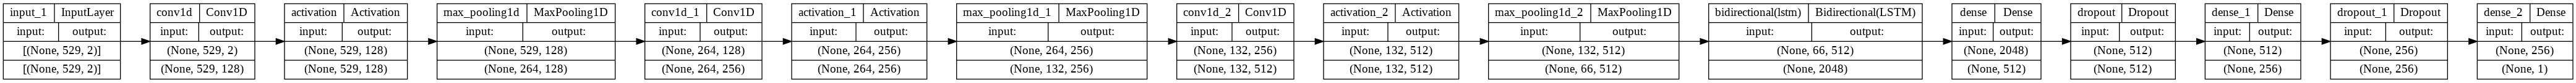

In [ ]:
#from keras.utils import plot_model

keras.utils.plot_model(model, to_file ='model.png',show_shapes=True,rankdir='LR')

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

save_dir = 'model_v6_nokfold/'
fold_var =2
# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
						monitor='val_accuracy', verbose=1, 
						save_best_only=True, mode='max')
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4)
callbacks_list = [checkpoint,earlystopping]
history=model.fit(x=data_train,y=l_train,validation_split=0.1,epochs=40,batch_size=16, callbacks=callbacks_list)
np.save(f'model_v6_nokfold/history_2.npy',history.history)

Epoch 1/40
411/411 [==============================] - ETA: 0s - loss: 1.6015 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.50068, saving model to model_v6_nokfold/model_2.h5
411/411 [==============================] - 27s 57ms/step - loss: 1.6015 - accuracy: 0.5000 - val_loss: 1.1228 - val_accuracy: 0.5007
Epoch 2/40
411/411 [==============================] - ETA: 0s - loss: 0.9126 - accuracy: 0.5254
Epoch 2: val_accuracy improved from 0.50068 to 0.56908, saving model to model_v6_nokfold/model_2.h5
411/411 [==============================] - 24s 59ms/step - loss: 0.9126 - accuracy: 0.5254 - val_loss: 0.7661 - val_accuracy: 0.5691
Epoch 3/40
411/411 [==============================] - ETA: 0s - loss: 0.8034 - accuracy: 0.5817
Epoch 3: val_accuracy improved from 0.56908 to 0.60602, saving model to model_v6_nokfold/model_2.h5
411/411 [==============================] - 26s 64ms/step - loss: 0.8034 - accuracy: 0.5817 - val_loss: 0.8203 - val_accuracy: 0.6060
Epoch 4/40
411/4

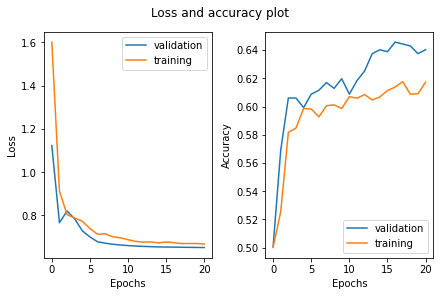

In [ ]:
#print(history.history.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
fig.suptitle(f'Loss and accuracy plot')

ax1.plot(history.history["val_loss"], label='validation')
ax1.plot(history.history["loss"], label='training')
ax1.legend(loc="upper right")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
#ax1.set_xlim(-0.5,10)
#ax1.set_ylim(0.1,0.7)
  
ax2.plot(history.history["val_accuracy"], label='validation')
ax2.plot(history.history["accuracy"], label='training')
ax2.legend(loc="lower right")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
#ax2.set_xlim(-0.5,10)
#ax2.set_ylim(0.5,0.9)
fig.savefig(f'model_v6/plot_2')
fig.show()

In [ ]:
# loading a history with np
# history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [ ]:
from keras import models

model=models.load_model('model_v6_nokfold/model_2.h5')

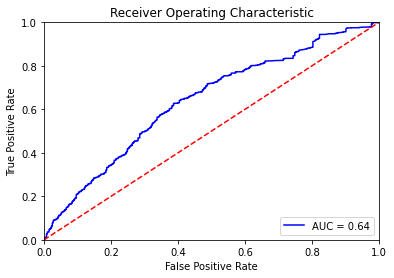

In [ ]:
# ROC Curve and AUC value with error
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict(data_test)
#y_preds_probs = np.argmax(probs,axis=1)
fpr, tpr, threshold = metrics.roc_curve(l_test, probs)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()